In [1]:
import glob
import gzip
import os
import shutil
import sys
import time
import warnings
import zipfile
from datetime import date

import cdsapi
import h5py
import numpy
import numpy as np
import pandas as pd
import urllib3
import xarray

warnings.filterwarnings("ignore")
import pycountry

sys.path.append(os.getcwd() + "/../cds-backend/code/")
import copy
import glob
import json

import csv

import cds_eua4 as eua
import numba
import pandas
import psutil
import requests
from numba import njit


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def datetime_to_seconds(dates, ref="1900-01-01T00:00:00"):
    """from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, "s")).astype(np.int64)


def seconds_to_datetime(seconds, ref="1900-01-01"):
    """from seconds to datetime64"""
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit="s", origin=ref)


import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt

matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (20, 10)
font = {
    "family": "normal",
    # 'weight' : 'bold',
    "size": 22,
}
matplotlib.rc("font", **font)

In [9]:
ingested_data = glob.glob('./interc_2005/*_02_ta.csv')
ingested_data

['./interc_2005/graw_02_ta.csv',
 './interc_2005/sip_02_ta.csv',
 './interc_2005/srs_02_ta.csv',
 './interc_2005/vaisgps_02_ta.csv']

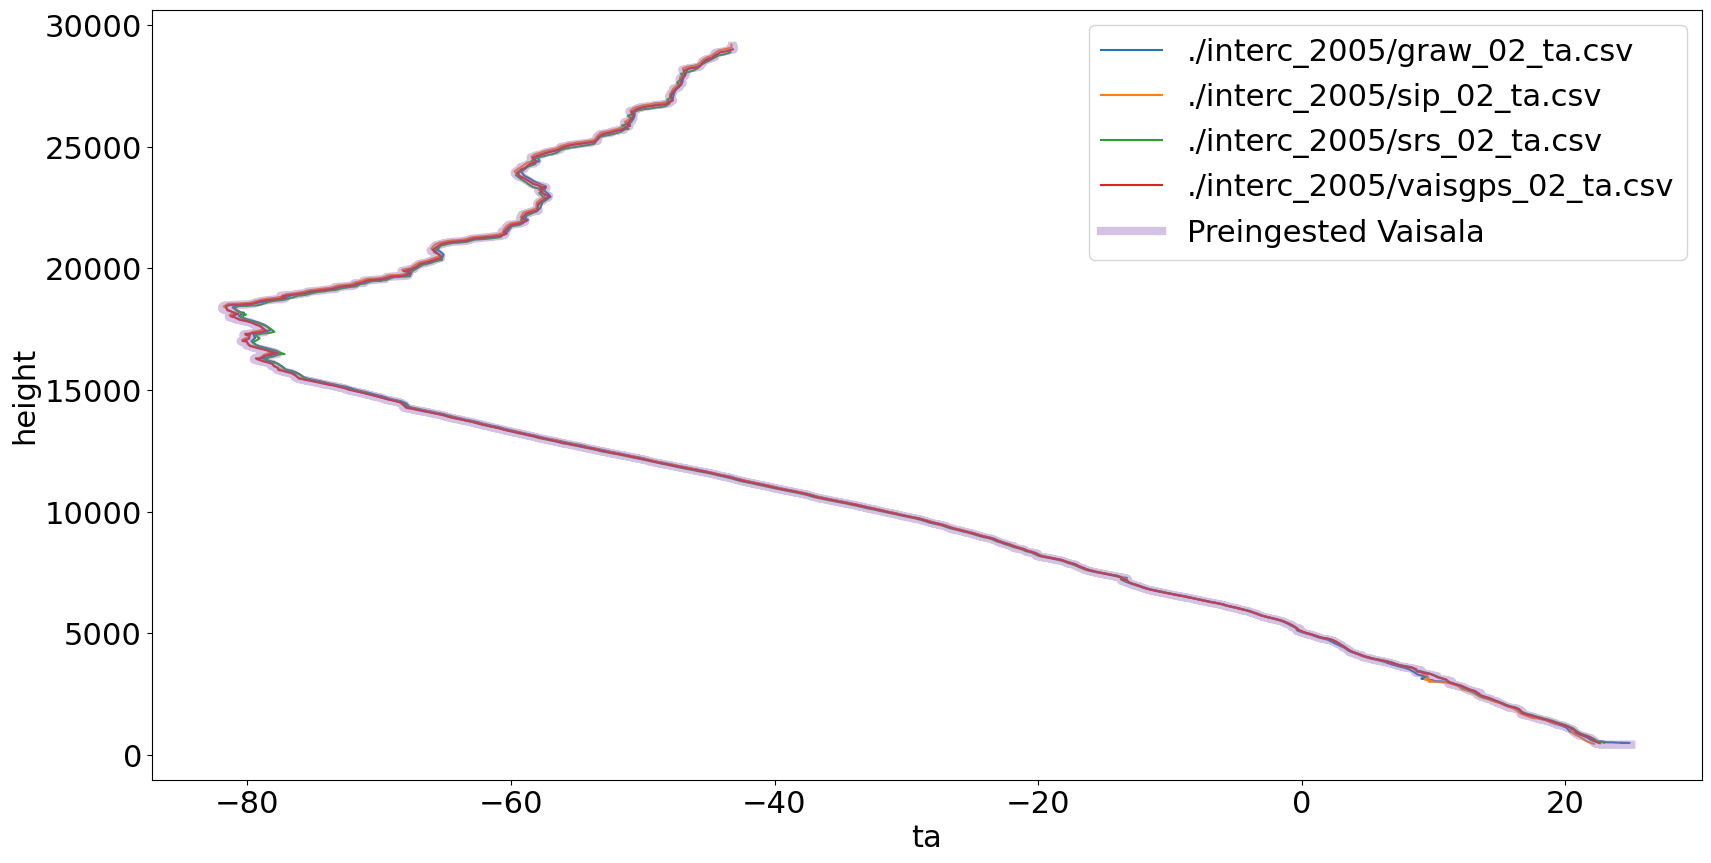

In [10]:
datasets = []
for i in ingested_data:
    df = pd.read_csv(i, delimiter='; ', decimal=',', names=['ta', 'z'])
    # print(i)
    # display(df)
    plt.plot(df.ta, df.z, label=i)
    
vais_df = pd.read_csv('./vaisala_ascents.csv')
vais_df = vais_df[vais_df.date_time == "07-02-2005 14:57:50.481"]
vais_df = vais_df[vais_df.height > 0]
plt.plot(vais_df.temperature, vais_df.height, label='Preingested Vaisala', alpha = 0.4, linewidth = 6)

plt.xlabel("ta")
plt.ylabel("height")
plt.legend()
plt.show()

In [12]:
ingested_data = glob.glob('./interc_2005/new_digi_csv/*.csv')
ingested_data

['./interc_2005/new_digi_csv/meisei.csv',
 './interc_2005/new_digi_csv/modem.csv',
 './interc_2005/new_digi_csv/vaisala.csv',
 './interc_2005/new_digi_csv/vaisala_gps.csv']

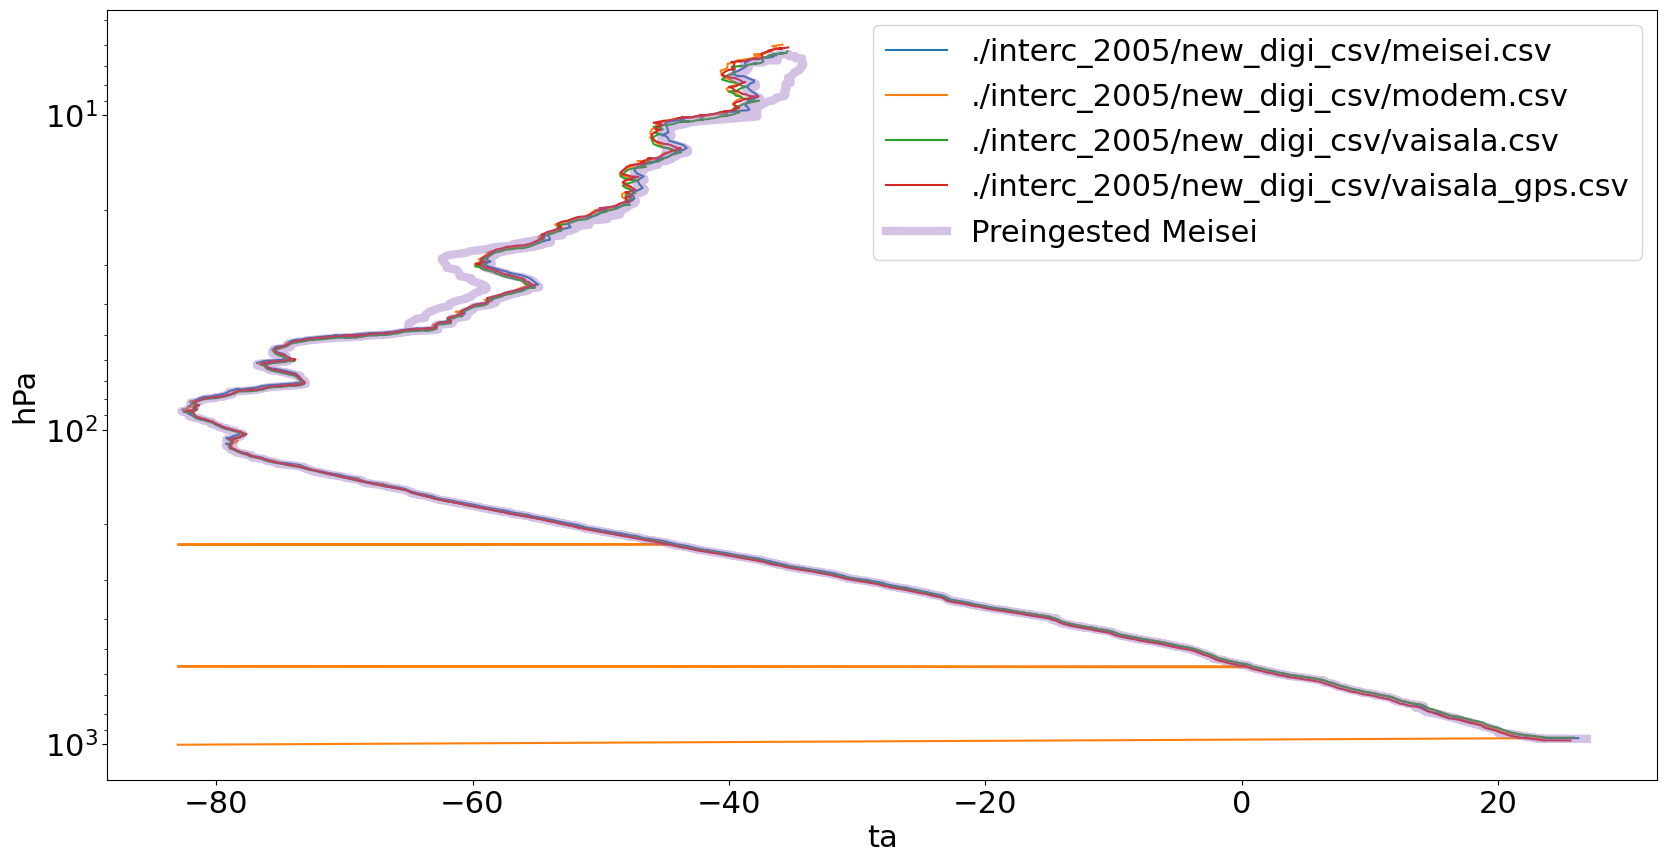

In [13]:
datasets = []
for i in ingested_data:
    df = pd.read_csv(i, delimiter='; ', decimal=',', names=['ta', 'z'])
    # print(i)
    # display(df)
    plt.plot(df.ta, df.z, label=i)
    
meis_df = pd.read_csv('./meisei_ascents.csv')
meis_df = meis_df[meis_df.Date == 20050208]
meis_df = meis_df[meis_df['Observation Time'] >= "14:00:54"]
meis_df = meis_df[meis_df['Observation Time'] < "15:30:54"]
meis_df = meis_df[meis_df['Temperature 0'] != "-----"]
meis_df['Temperature 0'] = np.array(meis_df['Temperature 0'],dtype=float)
meis_df['Barometric Pressure 0'] = np.array(meis_df['Barometric Pressure 0'],dtype=float)
meis_df = meis_df.reindex(index=meis_df.index[::-1])
plt.plot(meis_df['Temperature 0'], meis_df['Barometric Pressure 0'], label='Preingested Meisei', alpha = 0.4, linewidth = 6)

plt.xlabel("ta")
plt.ylabel("hPa")
ax = plt.gca()
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
plt.legend()
plt.show()

In [14]:
meis_df

,Unnamed: 0,Temperature 0,Observation Time,Wind Direction,Wind Speed,Humidity 0,Barometric Pressure 0,Positioning latitude,Positioning Longitude,Date
19141,7113,-65.0,15:30:53,126.85,17.30,-----,46.4,---------,----------,20050208
19140,7112,-65.0,15:30:52,126.66,17.52,1.0,46.0,---------,----------,20050208
19137,7109,-64.5,15:30:49,126.10,18.17,1.0,44.8,---------,----------,20050208
19136,7108,-64.4,15:30:48,125.93,18.39,1.0,44.4,---------,----------,20050208
19135,7107,-63.7,15:30:47,125.75,18.61,1.0,44.1,---------,----------,20050208
...,...,...,...,...,...,...,...,...,...,...
13763,1735,23.2,14:00:58,40.65,1.50,-----,959.8,---------,----------,20050208
13762,1734,23.5,14:00:57,36.62,0.81,75.1,960.3,-20.29718,57.49739,20050208
13761,1733,23.0,14:00:56,35.86,0.91,75.4,960.6,-20.29718,57.49739,20050208
13760,1732,23.6,14:00:55,37.90,1.64,75.7,960.7,-20.29717,57.49740,20050208


In [7]:
np.max(meis_df['Observation Time'])

'15:30:53'

In [8]:
np.min(meis_df['Observation Time'])

'14:00:54'